<a href="https://colab.research.google.com/github/allokkk/Car_Plate_Number_Detection/blob/main/Pre_processing_and_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-processing Work and Model

In [24]:
pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
# import the libarary
import numpy as np 
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import imageio as iio
import skimage.color
import skimage.filters
import easyocr
from lxml import etree
from random import sample, randint


In [26]:
#mount the google grive which has image dataset and labels
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# lets have all images and xml in one place
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/MyDrive/datasets/annotations/Cars1.xml
/content/gdrive/MyDrive/datasets/annotations/Cars0.xml
/content/gdrive/MyDrive/datasets/annotations/Cars106.xml
/content/gdrive/MyDrive/datasets/annotations/Cars10.xml
/content/gdrive/MyDrive/datasets/annotations/Cars101.xml
/content/gdrive/MyDrive/datasets/annotations/Cars102.xml
/content/gdrive/MyDrive/datasets/annotations/Cars103.xml
/content/gdrive/MyDrive/datasets/annotations/Cars107.xml
/content/gdrive/MyDrive/datasets/annotations/Cars100.xml
/content/gdrive/MyDrive/datasets/annotations/Cars104.xml
/content/gdrive/MyDrive/datasets/annotations/Cars105.xml
/content/gdrive/MyDrive/datasets/annotations/Cars68.xml
/content/gdrive/MyDrive/datasets/annotations/Cars297.xml
/content/gdrive/MyDrive/datasets/annotations/Cars407.xml
/content/gdrive/MyDrive/datasets/annotations/Cars149.xml
/content/gdrive/MyDrive/datasets/annotations/Cars251.xml
/content/gdrive/MyDrive/datasets/annotations/Cars116.xml
/content/gdrive/MyDrive/datasets/anno

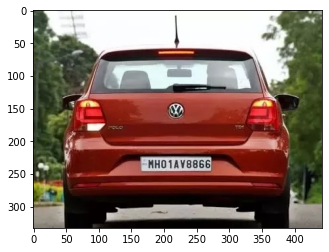

In [28]:
# load the image
image = iio.imread(uri="/content/gdrive/MyDrive/datasets/images/Cars198.png")
fig, ax = plt.subplots()
plt.imshow(image)


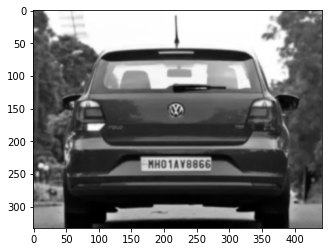

In [29]:
## convert the image to grayscale
gray_image = skimage.color.rgb2gray(image)

# blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)
fig, ax = plt.subplots()
plt.imshow(blurred_image, cmap="gray")

### Fearute and target extraction

In [30]:
# Resize the image into 200*200

IMAGE_SIZE = 200

img_dir = "/content/gdrive/MyDrive/datasets/images"
data_path = os.path.join(img_dir,'*g')

files = glob.glob(data_path)
files.sort()

X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [31]:
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width / IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text) / (height / IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text) / (width / IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text) / (height / IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [32]:
# join the path of image and annotation

path = '/content/gdrive/MyDrive/datasets/annotations'
text_files = ['/content/gdrive/MyDrive/datasets/annotations/'+f for f in sorted(os.listdir(path))]

y=[]
for i in text_files:
    y.append(resizeannotation(i))

### Display The Dataset

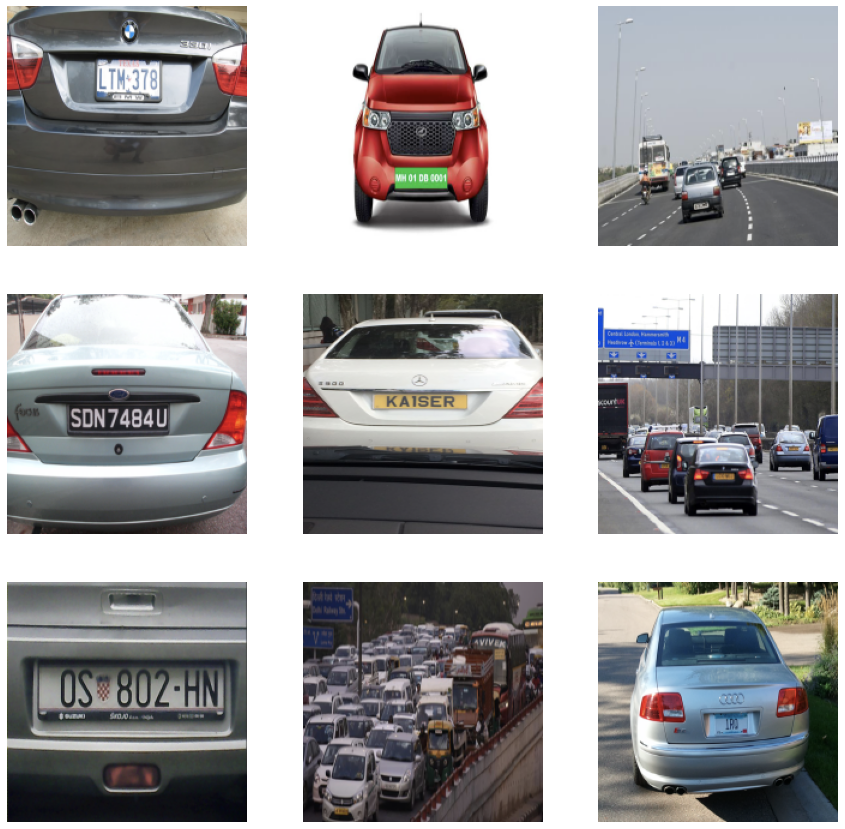

In [33]:
# display the dataset

sample_index = []
for i in range(9):
    sample_index.append(randint(0, len(X)))

plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))

## Checking size of image Dataset

In [34]:
print(f"X Shape : {np.array(X).shape}")
print(f"y Shape : {np.array(y).shape}")

X Shape : (433, 200, 200, 3)
y Shape : (433, 4)


In [35]:
# Normalizing the image
X=np.array(X)
y=np.array(y)
X = X / 255
y = y / 255

In [36]:
print(np.array(X).shape)
print(np.array(y).shape)

(433, 200, 200, 3)
(433, 4)


## MODEL

In [37]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet50 import ResNet50


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

#### VGG19 Model

In [39]:
model = Sequential()
model.add(VGG19(weights="imagenet", include_top=False, input_shape=(200,200, 3)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-7].trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_2 (Dropout)         (None, 18432)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               4718848   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                

Model Traning 

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
10/10 [==============================] - 185s 18s/step - loss: 0.0927 - accuracy: 0.5166 - val_loss: 0.0735 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 177s 18s/step - loss: 0.0714 - accuracy: 0.5530 - val_loss: 0.0700 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 180s 18s/step - loss: 0.0652 - accuracy: 0.5530 - val_loss: 0.0697 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 182s 18s/step - loss: 0.0622 - accuracy: 0.5530 - val_loss: 0.0703 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 178s 18s/step - loss: 0.0605 - accuracy: 0.5530 - val_loss: 0.0678 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 178s 18s/step - loss: 0.0587 - accuracy: 0.5530 - val_loss: 0.0683 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 177s 18s/step - loss: 0.0585 - accuracy: 0.5530 - val_loss: 0.0674 - val_accuracy: 0.5000
Epoch 

### Resnet 50 model

In [41]:
model2 = Sequential()
model2.add(ResNet50(weights='imagenet',include_top=False, input_shape=(200,200, 3)))
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(500, activation="relu"))
model2.add(Dense(250, activation="relu"))
model2.add(Dense(150, activation="relu"))
model2.add(Dense(4, activation="sigmoid"))

model2.layers[-7].trainable = False

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_3 (Dropout)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 500)               50176500  
                                                                 
 dense_13 (Dense)            (None, 250)               125250    
                                                                 
 dense_14 (Dense)            (None, 150)               37650     
                                                                 
 dense_15 (Dense)            (None, 4)                

In [42]:
import tensorflow as tf

In [43]:
model2.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'],)


history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
10/10 [==============================] - 62s 6s/step - loss: 0.0812 - accuracy: 0.3709 - val_loss: 0.0381 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 51s 5s/step - loss: 0.0434 - accuracy: 0.5232 - val_loss: 0.0236 - val_accuracy: 0.5682
Epoch 3/10
10/10 [==============================] - 53s 5s/step - loss: 0.0233 - accuracy: 0.4735 - val_loss: 0.0202 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 51s 5s/step - loss: 0.0201 - accuracy: 0.5199 - val_loss: 0.0180 - val_accuracy: 0.5227
Epoch 5/10
10/10 [==============================] - 51s 5s/step - loss: 0.0180 - accuracy: 0.5762 - val_loss: 0.0191 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 53s 5s/step - loss: 0.0168 - accuracy: 0.4901 - val_loss: 0.0163 - val_accuracy: 0.5455
Epoch 7/10
10/10 [==============================] - 50s 5s/step - loss: 0.0161 - accuracy: 0.5695 - val_loss: 0.0160 - val_accuracy: 0.5455
Epoch 8/10
10/10 [==